In [1]:
pwd

'/home/jose/Desktop/GitHub/Bidimensional_TDMA_inversion/Examples'

In [2]:
from linker import *
%matplotlib notebook

# Tandem DMA measurements:

## Setup DMA-1 & DMA-2

Include the properties of the DMA used including:

- model: The type of DMA. Two options are available "nano" and "long". Internally, the code will select the DMA length, internal, and external radii needed for the DMA transfer function calculation.
- flow_aerosol: Aerosol flow in L/min.
- flow_sheath: Sheath flow in L/min.
- Voltage: The DMA current voltage. Add a value to initialize the calculation of properties. This value is updated when needed and will update all the DMA properties depending on it.
- L_eff: Value used for determining the DMA penetration efficiency [A Reineking and J Porstendörfer (1986)](https://www.tandfonline.com/doi/abs/10.1080/02786828608959112).
- Pressure and Temperature: Aerosol properties in Pa and K, respectively.
- Charge_limit: This variable is only used when the charge distribution is known and is a bipolar distribution [A Wiedensohler (1988)](https://www.sciencedirect.com/science/article/pii/0021850288902789).

Here we assume that both sheath flow and aerosol flow are balanced.

In [3]:
DMA_props1 = {
    "model":         "nano",
    "flow_aerosol":  1.5,
    "flow_sheath":   4.5,
    "Voltage":       1,
    "L_eff":         13,
    "Pressure":      101000,
    "Temperature":   300,
    "Charge_limit":  10}

# Setup DMA
dma1 = DMA_tDMA_inversion_tools.DMA(DMA_props1)

DMA_props2 = {
    "model":         "long",
    "flow_aerosol":  1.5,
    "flow_sheath":   7,
    "Voltage":       1,
    "L_eff":         13,
    "Pressure":      101000,
    "Temperature":   300,
    "Charge_limit":  10}

# Setup DMA
dma2 = DMA_tDMA_inversion_tools.DMA(DMA_props2)

## Fix voltage in DMA-2 and scan with DMA-1

In [4]:
measurements_data = pd.read_csv("data/measurements_data.dat")
measurements_data

,ESP_V (kV),V1,V2,run,R,Dp1,Dp2,Mobility (m2/s/V)
0,11.0,5,500,1,2.082180,2.447685,63.029491,3.394660e-05
1,11.0,154,500,1,2.776017,13.852126,63.029491,1.096821e-06
2,11.0,304,500,1,3.668181,19.597870,63.029491,5.574155e-07
3,11.0,454,500,1,67.845247,24.094931,63.029491,3.736555e-07
4,11.0,604,500,1,219.840313,27.945700,63.029491,2.810149e-07
...,...,...,...,...,...,...,...,...
583,11.0,2401,4000,14,60.342489,58.246453,214.262569,7.069263e-08
584,11.0,2550,4000,14,52.780963,60.205577,214.262569,6.654239e-08
585,11.0,2700,4000,14,47.208448,62.118885,214.262569,6.285244e-08
586,11.0,2850,4000,14,40.191863,63.984939,214.262569,5.955022e-08


In [5]:
measurements_data_avg = measurements_data.groupby(by=["ESP_V (kV)","V2", "V1"]).agg((np.mean))
measurements_data_avg.drop(columns=['run'],inplace = True)
measurements_data_avg.reset_index(inplace = True)
measurements_data_avg.head()

,ESP_V (kV),V2,V1,R,Dp1,Dp2,Mobility (m2/s/V)
0,11.0,250,5,1.996389,2.447685,43.548602,3.394660e-05
1,11.0,250,154,2.132420,13.852126,43.548602,1.096821e-06
2,11.0,250,304,3.377515,19.597870,43.548602,5.574155e-07
3,11.0,250,454,28.418321,24.094931,43.548602,3.736555e-07
4,11.0,250,604,39.008371,27.945700,43.548602,2.810149e-07


In [6]:
measurements_data_avg.tail()

,ESP_V (kV),V2,V1,R,Dp1,Dp2,Mobility (m2/s/V)
289,11.0,5500,2401,28.635085,58.246453,265.979544,7.069263e-08
290,11.0,5500,2550,26.502153,60.205577,265.979544,6.654239e-08
291,11.0,5500,2700,24.019136,62.118885,265.979544,6.285244e-08
292,11.0,5500,2850,18.277443,63.984939,265.979544,5.955022e-08
293,11.0,5500,3000,15.458273,65.816925,265.979544,5.657767e-08


<IPython.core.display.Javascript object>


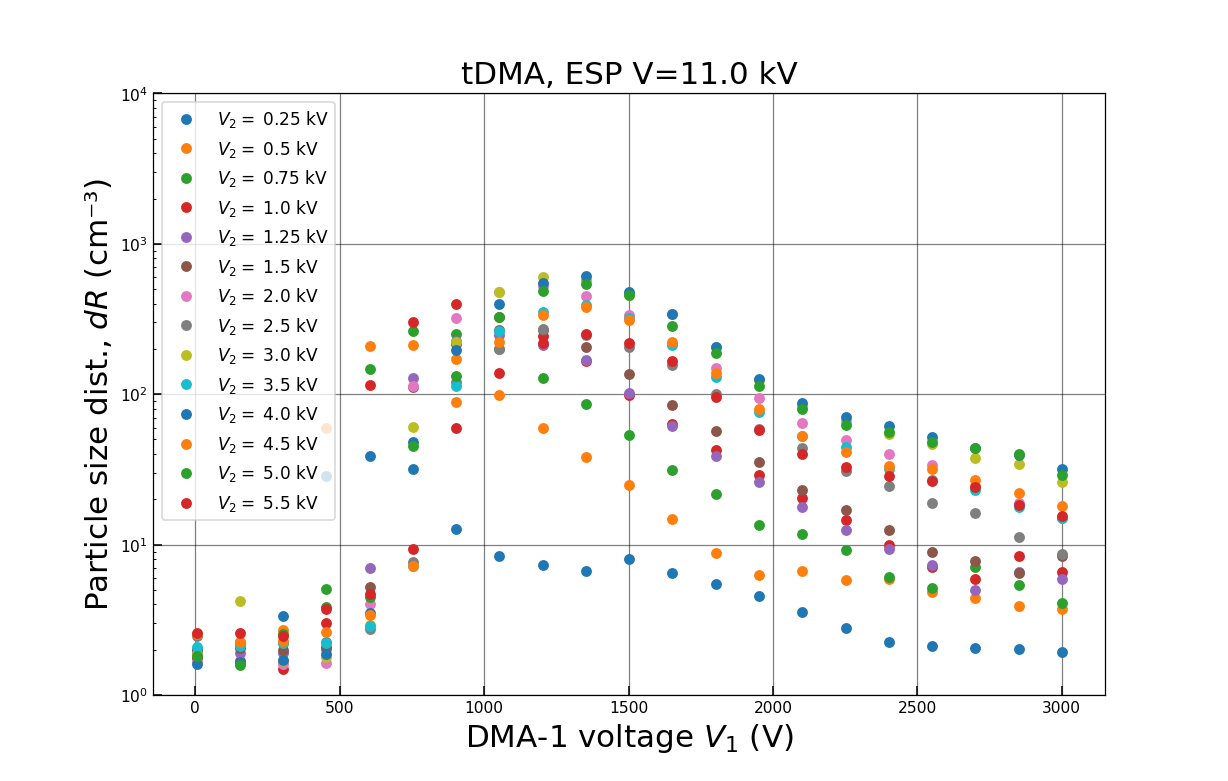

In [7]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'])
V2s = np.unique(measurements_data_avg['V2'])

for espV in ESPV:
    tDMA_support.Plot_ESPV(espV, V2s, measurements_data_avg)

## Raw tDMA inversion

As a first approximation we will conduct a raw inversion where we will neglect the DMA transfer function of both DMAs. Therefore, DMA-2 will give us the particle diameter and DMA-1 will give us the number of charges by directly matching the particle mobility $Z_p$ to the one defined by the DMA transfer function center mobility $Z_p^*$.

### 1. Particle sizes

We can interpret the second DMA to be fixing a size, by assuming that most of these particles are singly charged (which is expected to be a good approximation after particles pass through the neutralizer). Such size can be found considering the central mode electrical mobility when DMA2 is at voltage $V_2$,
$$Z_{2p}^*(V_2) = \frac{q_{2s}+q_{2c}}{4\pi  \Lambda_2 V_2}$$
where $q_{2s}$ and $q_{2c}$ are the sheath in and out flows (m$^3$/s) on DMA2, respectively. Also, the $\Lambda_2 = L_2/\log(R_{2,1}/R_{2,2})$ is a purely geometrical parameter depending on DMA2 length $L_2$, inner $R_{2,1}$ and outer $R_{2,2}$ radii. Being equivalent to,
$$ Z_{2p} = \frac{z_2e}{f},\,\,\,z_2=1$$
where $e=1.602\cdot 10^{-19}$ C is the value of one individual electrical charge, and $$f=\frac{3\pi \eta D_p}{C_c(D_p)}$$ is the particle's friction coefficient (kg$\cdot$s$^{-1}$) in the Stokes regime (Reynolds number lower than $<10$). Also, $\eta$ is the gas viscosity (Pa$\cdot$s), $D_p$ is the particle's mobility diameter (m), and $$C_c(D_p)=1+\mathrm{Kn}\left(2.34+1.05\exp[-0.39/\mathrm{Kn}]\right)$$ is the Cunningham correction factor. This factor corrects the friction coefficient for the slip of gas molecules at the interface which depends on both the mean free path of the gas $\lambda$ and $D_p$ as expressed by the dimensionless Knudsen number $\mathrm{Kn}=\lambda/D_p$.

### 2. Particle charges

Now that we have approximated the size of particles, we can do a simple calculation of the mobilities they may have when carrying multiple charges. Then, when DMA1 is at a voltage $V_1$ it will select particles with an electrical mobility,
$$Z_{1p}^*(V_1) = \frac{q_{1s}+q_{1c}}{4\pi  \Lambda_1 V_1} = \frac{z_1e}{f}$$

This equation can be solved to find $z_1$ given that we know particles' diameter $D_2$.

In [8]:
# We first calculate Z_p* for both DMA's
measurements_data_avg["Zp1"] = measurements_data_avg.progress_apply(tDMA_support.Find_DMA_central_Zp,
                                                                    axis=1,args=(1,dma1))
measurements_data_avg["Zp2"] = measurements_data_avg.progress_apply(tDMA_support.Find_DMA_central_Zp,
                                                                    axis=1,args=(2,dma2))

100%|█████████████████████████████████████| 294/294 [00:00<00:00, 156666.93it/s]


In [9]:
# Estimate the charges on DMA1
z1_estim = measurements_data_avg.progress_apply(tDMA_support.Find_charge_givenDp,axis=1)
df = pd.DataFrame(z1_estim,columns=['z1_estim'])
measurements_data_avg[['z1_raw',
                       'z1_raw_error']] = pd.DataFrame(df['z1_estim'].tolist(), index=df.index)
del df,z1_estim  

100%|███████████████████████████████████████| 294/294 [00:00<00:00, 1912.44it/s]


<IPython.core.display.Javascript object>


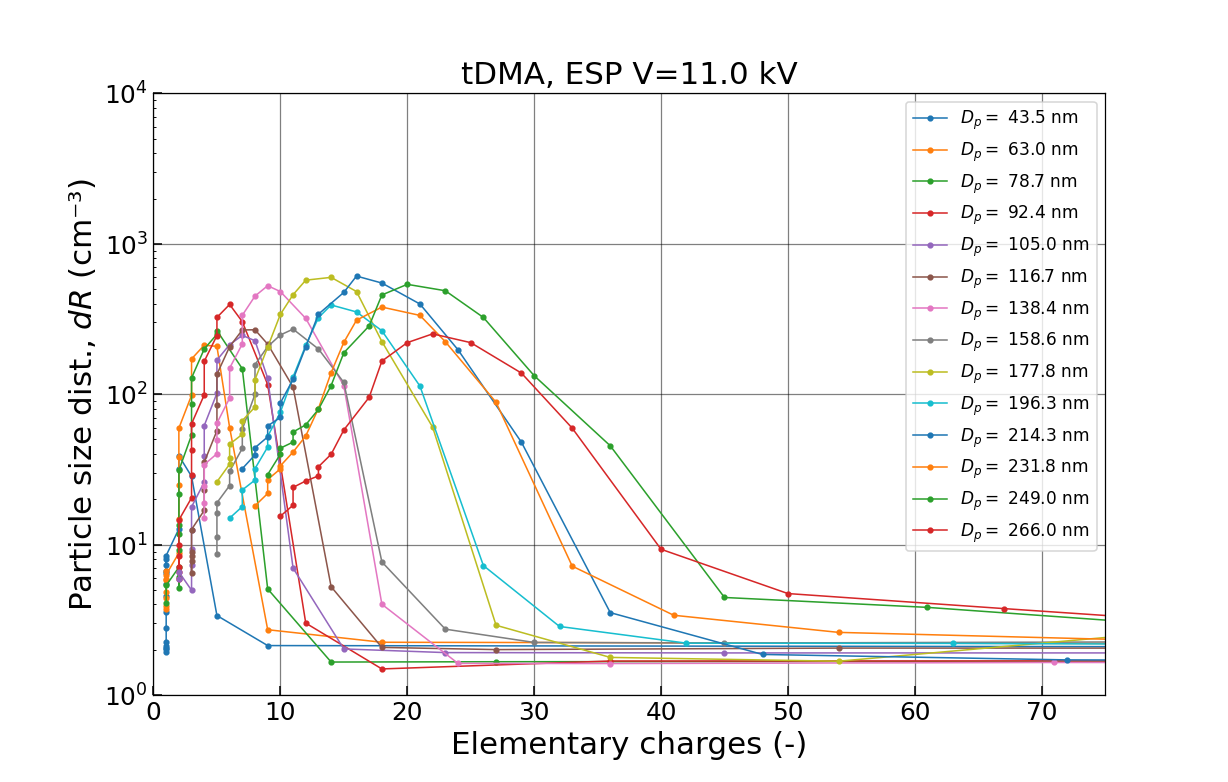

In [10]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'])

for espV in ESPV:
    tDMA_support.Plot_ESPV(espV,V2s, measurements_data_avg,
              line=True,
              row='z1_raw',
              spline=False,
              D_legend=True,
              LogYscale=True,
              export=False,
              xmax = 75)

## Deconvolution TDMA

Here we conduct the formal deconvolution of the TDMA measuremehnts. The reading of the CPC $R(V_2,V_1)$ in number concentration when the nDMA is at $V_1$ and the LDMA is at voltage $V_2$ is given by,

$$
    R(V_2,V_1) = \sum_z\int_{D_p}\left[\sum_{z_n}\Omega_2(Z_p|V_2)T_2(D_p)f_2(z_n,D_p)\right]\Omega_1(Z_p|V_1)T_1(D_p)f_1(z,D_p)\frac{\partial N}{\partial D_p}\, dD_p
$$

where: 
- $\Omega_1(Z_p|V_1)$ and $\Omega_2(Z_p|V_2)$ are the transfer functions of the nDMA and LDMA, respectively for particles with electrical mobility $Z_p$
- $T_1(D_p)$ and $T_2 (D_p)$ are the penetration efficiencies of the nDMA and LDMA, respectively for particles of diameter $D_p$
- The charge fraction particles entering the nDMA (directly of interest) and entering the LDMA (assumed to be that described by [A Wiedensohler (1988)](https://www.sciencedirect.com/science/article/pii/0021850288902789) as particles passed through bipolar ionizers prior to the LDMA) are $f_1(z,D_p)$ and $f_2(z_n,D_p)$, respectively.  $z_n$ and $z$ denote the particle charges after bipolar ionization and the charges at the ESP outlet, respectively. 

### 1. Penetration efficiency

Penetration efficiency through the DMA is computed based on the
parameterized results by [A Reineking and J Porstendörfer (1986)](https://www.tandfonline.com/doi/abs/10.1080/02786828608959112).

$$T_l = 0.82\exp(-11.5u)+0.1\exp(-70.0u)+0.03\exp(-180.0u)+0.02\exp(-340.0u)$$

where $u = \frac{D_{ab} l_{eff}}{q_{sa}}$, $l_{eff}$ is the parameterized
effective diffusion length, and $q_{sa}$ is the aerosol flow rate through the DMA,
and $D_{ab}$ is the particle diffusion coefficient.

### 2. Charging efficiency

Charging efficiency (charge equilibrium) obtained in the bipolar charger
is computed based on the parameterized measurements by [A Wiedensohler (1988)](https://www.sciencedirect.com/science/article/pii/0021850288902789). 

$$T_c(k) = 10^\left\{ \sum_{i=1}^6 a_i (k) \left[ \ln \left(\frac{D_p}{nm}\right) \right]^{i-1} \right \}$$

where $k = -2,-1,1,2$ is the number and polarity of particle charge and $a_i$ are
empirical coefficients based on Fuchs theory. This equation is valid for 
$1\, nm<D_p<1000\, nm$ for $k=[-1, 1]$ and $20\, nm<D_p<1000\, nm$ for $k=[-2, 2]$.

![params_Wiedensohler](https://user-images.githubusercontent.com/62391931/229378603-ebd12d6e-b9e0-475c-9eea-e2bc0a9c916e.png)

For $k \ge \pm 3$, electric charges are obtained by randomly sampling a number of elementary charges ($z_p$) from the Boltzmann distribution [Maricq, 2008](https://www.sciencedirect.com/science/article/pii/S0021850207002017),

$$
    f(z_p)=\left(\frac{K_Ee^2}{\pi d_mk_BT}\right)^{1/2}\exp \left(\frac{-K_Ez_p^2e^2}{d_mk_BT}\right)
$$

where $K_E=9.0\cdot 10^{9}$~Nm$^2$/C$^2$, $k_B$ is the Boltzmann constant, $e$ is the elementary charge, and $d_m$ is the mobility diameter of the aggregate. For a fixed mobility diameter can be interpreted as a normal distribution with variance $\sigma^2=(d_mk_BT)/(2K_Ee^2)$ where the variable is the number of elemental charges $z_p$,

$$
    f(z_p)\rvert_{d_m}=\left(\frac{1}{2\pi \sigma}\right)^{1/2}\exp \left(\frac{-z_p^2}{2\sigma^2}\right)
$$

### 3. Fredholm Matrix form of the inversion problem

Finally, $(\partial N/\partial D_p)dD_p$ is the number concentration of particles with a diameter between $D_p$ and $D_p+dD_p$. The inversion equation can be discretized into $\theta_1$ charge bins and into $\theta_2$ size bins determined by the number of measured voltages $V_1$ and $V_2$, respectively. This makes a total of $\zeta = \theta_1\times\theta_2$ measurement points that can be represented as pairs $(z_j,D_{p,j})$ where $j\in[1,\zeta]$. We can define the unknown corresponding to the charge fraction multiplied by the size distribution $x_j=f_1(z_j,D_{p,j} )[\partial N/\partial D_{p,j} ]\Delta D_{p,j}$ . This way of discretizing the problem greatly simplifies the solution of the inversion equation as the left-hand side as well as the unknown becomes 1d vectors. Therefore, the triple sum on the right-hand side of the inversion equation becomes a two-dimensional matrix,

$$
    A_{ij}(z_j,D_{p,j}|\mathbf{V}_i) =\sum_{j=1}^{\zeta} \left[\sum_{z_n}\Omega_2(Z_{p,j}|V_{2,i})T_2(D_{p,j})f_2(z_n,D_{p,j})\right]\Omega_1(Z_{p,j}|V_{1,i})T_1(D_{p,j})
$$

where $i\in[1,\zeta]$ is the index for the number of pairs of voltages $\mathbf{V}_i=(V_{1,i},V_{2,i})$. Considering $\mathbf{b}_i=R(\mathbf{V}_i)$, then the inversion equation is rewritten in a matrix form as,

$$
    \mathbf{b}=\mathbf{A}\mathbf{x}+\mathbf{\varepsilon}
$$

where $\mathbf{\varepsilon}$ is the vector of experimental error. The dimensions of these matrices are $\mathbf{b}\in \mathbb{R}^{\zeta}$, $\mathbf{A}\in \mathbb{R}^{\zeta}\times \mathbb{R}^{\zeta}$, and $\mathbf{x}\in \mathbb{R}^{\zeta}$. To better visualize these matrices and to ease their computational implementation, we consider  $A_{i,j}^{(1)} = \Omega_1(Z_{p,j}|V_{1,i})T_1(D_{p,j})$ and $A_{i,j,k}^{(2)} = \Omega_2(Z_{p,j}|V_{2,i})T_2(D_{p,j})f_2(z_{n,k},D_{p,j})$. Therefore, the different matrices of this inversion are expressed as,

$$
\mathbf{b} = \left(\begin{array}{c}
       b_1(V_{1,1},V_{2,1})    \\
       \vdots \\   
       b_{\zeta}(V_{1,\zeta},V_{2,\zeta})
\end{array} \right);\hspace{1cm} 
\mathbf{x} = \left( \begin{array}{c}
       x_1(z_1,D_{p,1} )    \\[0.3em]
       \vdots \\[0.3em]        
       x_{\zeta}(z_{\zeta},D_{p,\zeta} )
\end{array} \right)
$$

$$
\mathbf{A} = \left(\begin{array}{ccc}
  A_{1,1}^{(1)}[\sum_{k=1}^{k_{\mathrm{max}}} A_{1,1,k}^{(2)}]  & \cdots & 
  A_{1,\zeta}^{(1)}[\sum_{k=1}^{k_{\mathrm{max}}} A_{1,\zeta,k}^{(2)}] \\
  \vdots  & \ddots  & \vdots  \\
  A_{\zeta,1}^{(1)}[\sum_{k=1}^{k_{\mathrm{max}}} A_{\zeta,1,k}^{(2)}]  & \cdots & 
  A_{\zeta,\zeta}^{(1)}[\sum_{k=1}^{k_{\mathrm{max}}} A_{\zeta,\zeta,k}^{(2)}]  
\end{array} \right)
$$

where $k_{\mathrm{max}}$ is the maximum number of charges considered for bipolar ionization. The matrix inversion equation is an ill-posed Fredholm equation solved  using a Tikhonov regularization. Under this method, the matrix inversion equation can be solved as (see equation 1.15 from [Vogel 2002](https://epubs.siam.org/doi/book/10.1137/1.9780898717570)),

$$
   \widetilde{\mathbf{x}} = (\mathbf{A}^t\mathbf{A}+\alpha \mathbf{I})^{-1}\mathbf{A}^t\mathbf{b}
$$

where the exponent $t$ refers to the transpose matrix, $\textbf{I}$ is the identity matrix (with dimensions $\zeta\times\zeta$) and $\alpha \in [0,\infty]$ is the regularization parameter. When $\alpha\rightarrow 0$ then the filtering of noise is insufficient and the result will be very oscillatory. On the other hand, when $\alpha\rightarrow\infty$ the noise is considerably reduced at the cost of overly smoothing the inverted curve. Therefore an optimum $\alpha$ is here selected by comparison between the original data and the convolution of the deconvoluted data.

In [11]:
zmax = 250

In [12]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'].values)
V2s = np.unique(measurements_data_avg.V2.values)

measurements_data_avg['N_deconv'] = 0
measurements_data_avg['f1'] = 0.
measurements_data_avg['R_conv'] = 0.
measurements_data_avg['z1'] = 0

for espV in ESPV:
    alpha = 1e-01
    # Select data for the specific case
    data = measurements_data_avg[measurements_data_avg['ESP_V (kV)'] == espV].copy()
    # Select the vector of voltages V=[V1,V2] and pairs diameter-charge Dpz=[Dp,z]
    V,Dpz = tDMA_support.Find_Dp_charges(data)
    # Determine the TDMA deconvolution matrix
    A = tDMA_support.tDMA_convolution_matrix(V,Dpz,dma1,dma2,zn_max=2)
    # Deconvolution
    N_deconv = tDMA_support.Deconvolution(data.R.values, A, alpha)
    N_deconv[N_deconv< 0] = 0.0
    # Reconvolution (only for comprobation)
    R_conv = tDMA_support.Convolution(A, N_deconv)
    # Save the charges
    charges = Dpz[:,1]
    # Save the results of the current dataset
    # Determine a charge fraction
    f1 = tDMA_support.Get_charge_fraction(charges, N_deconv, zmax=zmax)
    measurements_data_avg = tDMA_support.Set_column_ESPdata(measurements_data_avg,
                                               data.index.values,
                                               N_deconv,"N_deconv")
    measurements_data_avg = tDMA_support.Set_column_ESPdata(measurements_data_avg,
                                               data.index.values,
                                               f1,"f1")
    measurements_data_avg = tDMA_support.Set_column_ESPdata(measurements_data_avg,
                                               data.index.values,
                                               R_conv,"R_conv")
    measurements_data_avg = tDMA_support.Set_column_ESPdata(measurements_data_avg,
                                               data.index.values,
                                               charges.astype(int),"z1")
    del A,N_deconv,R_conv,data,V,Dpz,charges

len(V1), len(V2), len(charges), len(R) 21   14   21   294
charges:  [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41]
Dp:  [ 43.55  63.03  78.69  92.42 104.95 116.66 138.4  158.61 177.82 196.31
 214.26 231.8  249.02 265.98]


/home/jose/Desktop/GitHub/Bidimensional_TDMA_inversion/src/tDMA_support.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c_name].iloc[i] = data[k]


<IPython.core.display.Javascript object>


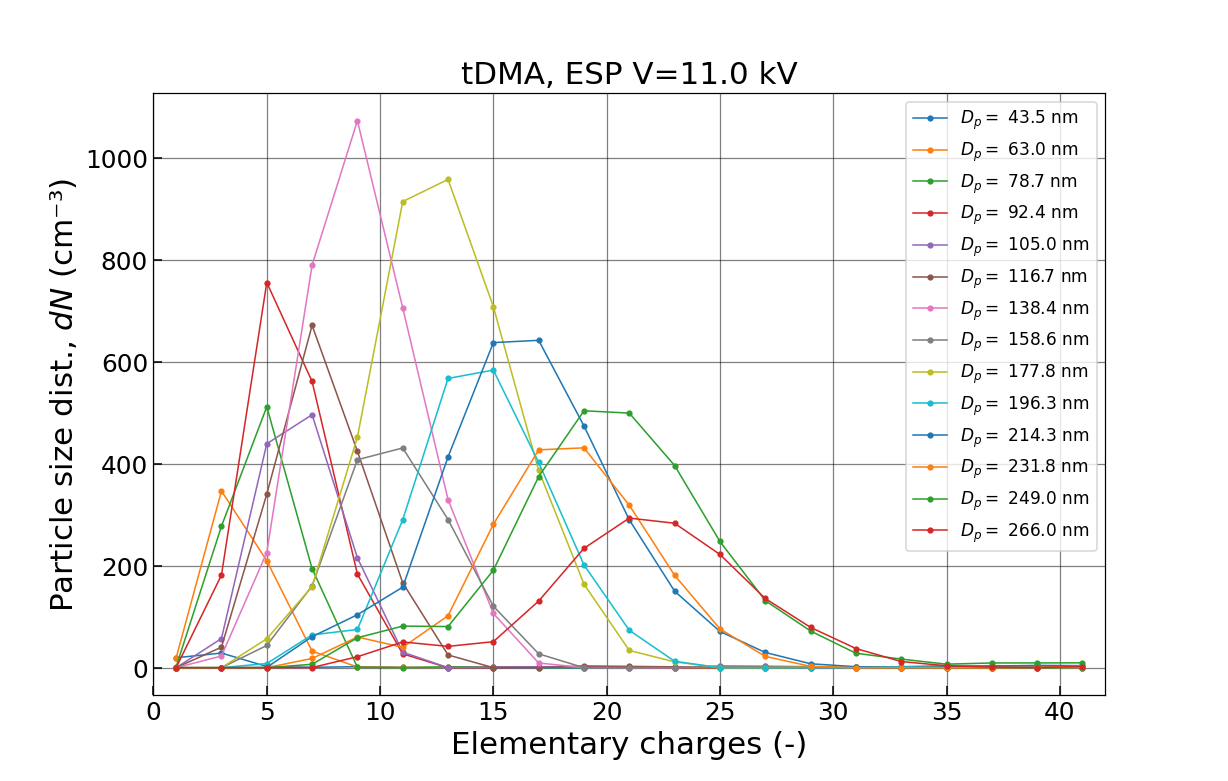

In [13]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'])

for espV in ESPV:
    tDMA_support.Plot_ESPV(espV,V2s, measurements_data_avg,
              line=True,
              row='z1',
              column='N_deconv',
              spline=False,
              D_legend=True,
              LogYscale=False,
              export=False,
              xmax = 42,
              prefix="tDMA_deconv_")

## 2 steps deconvolution

A two steps deconvolution procedure is proposed.

In [14]:
measurements_data_avg2s = measurements_data_avg.copy()

ESPV = np.unique(measurements_data_avg2s['ESP_V (kV)'].values.copy())

measurements_data_avg2s["R1p"] = 0.
measurements_data_avg2s["N1p"] = 0.
measurements_data_avg2s["R1p_conv"] = 0.
measurements_data_avg2s["f1"] = 0.
measurements_data_avg2s["zDMA1"] = 0
measurements_data_avg2s["R1p_conv_error"] = 0

alpha = 1e-01

for espV in ESPV:
    data = measurements_data_avg2s[measurements_data_avg2s["ESP_V (kV)"] == espV].copy()
    V2_vec = np.unique(data['V2'].values.copy())
    for v2 in V2_vec:
        data2 = data[data["V2"] == v2].copy()
        R1p = tDMA_support.R1p_simplified(v2,data2.Dp2.values * 1e-09,data2.R.values,dma2)
        zDMA1 = np.arange(1,2*len(data2.V1.values)+1,2)
        N1p,R1p_conv,R1p_conv_error = tDMA_support.Deconvolute_singleDMA_charges(dma1,
                                                                                 zDMA1,
                                                                                 R1p,
                                                                                 data2.Dp2.values * 1e-09,
                                                                                 data2.V1.values,
                                                                                 check=False)
        N1p[N1p < 0.0] = 0.0
        # Determine a charge fraction
        f1 = tDMA_support.Get_charge_fraction(zDMA1, N1p, zmax=zmax)
        measurements_data_avg2s = tDMA_support.Set_column_ESPdata(measurements_data_avg2s,
                                                  data2.index.values,
                                                  zDMA1,"zDMA1")
        measurements_data_avg2s = tDMA_support.Set_column_ESPdata(measurements_data_avg2s,
                                                  data2.index.values,
                                                  N1p,"N1p")
        measurements_data_avg2s = tDMA_support.Set_column_ESPdata(measurements_data_avg2s,
                                                  data2.index.values,
                                                  R1p,"R1p")
        measurements_data_avg2s = tDMA_support.Set_column_ESPdata(measurements_data_avg2s,
                                                  data2.index.values,
                                                  R1p_conv,"R1p_conv")
        measurements_data_avg2s = tDMA_support.Set_column_ESPdata(measurements_data_avg2s,
                                                  data2.index.values,
                                                  R1p_conv_error,"R1p_conv_error")
        measurements_data_avg2s = tDMA_support.Set_column_ESPdata(measurements_data_avg2s,
                                                  data2.index.values,
                                                  f1,"f1")
        del data2,R1p,N1p
    del data,V2_vec

/home/jose/Desktop/GitHub/Bidimensional_TDMA_inversion/src/tDMA_support.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c_name].iloc[i] = data[k]
/home/jose/Desktop/GitHub/Bidimensional_TDMA_inversion/src/tDMA_support.py:249: RuntimeWarning: divide by zero encountered in divide
  R_conv_error = np.sqrt(np.power(R-R_conv,2))/R


## Comparison of inversion approaches

To ensure that the inverted result is reliable, we here compare it with the 2 aforementioned methods. This includes the so called "raw inversion" where the DMA transfer functions are neglected and a "2-step deconvolution" which is a deconvolution doing some assumptions to simplify the problem at the cost of lossing accuracy.

<IPython.core.display.Javascript object>


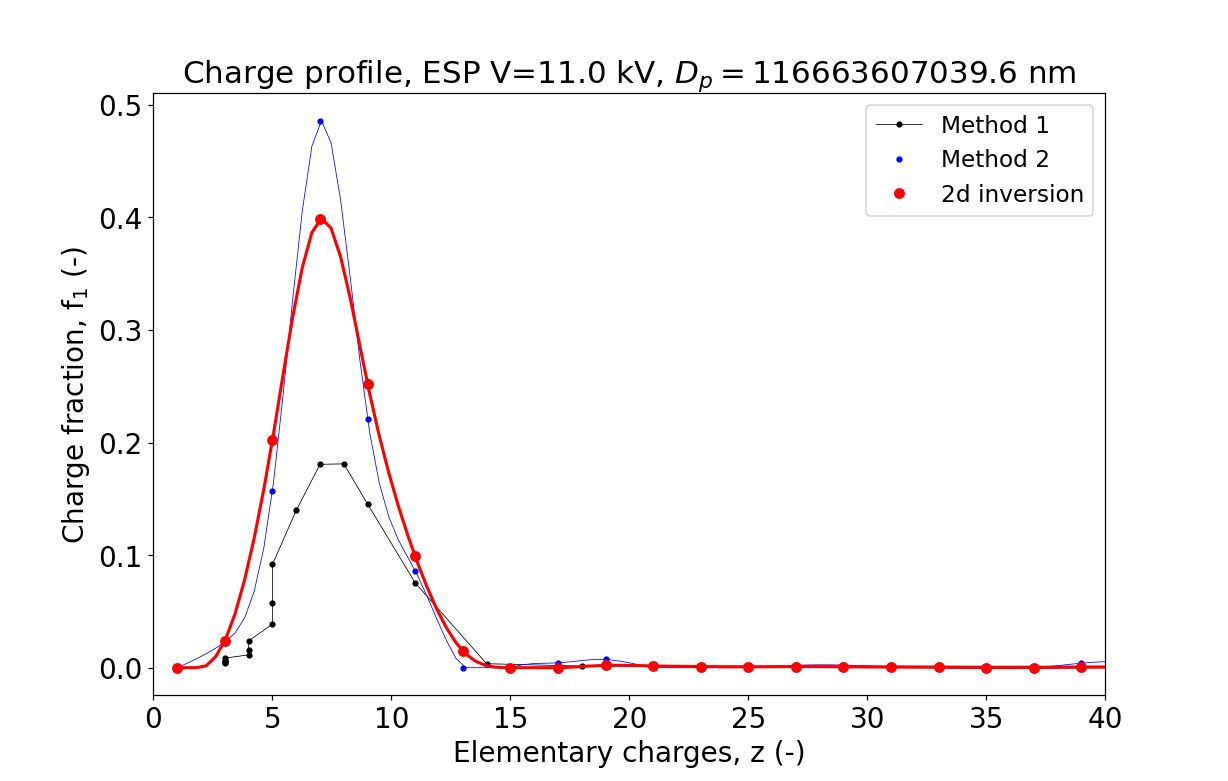

In [15]:
espV = ESPV[-1]

data = measurements_data_avg2s[measurements_data_avg2s["ESP_V (kV)"] == espV].copy()
V2_vec = np.unique(data['V2'].values)

for i in [5,]: #range(len(V2_vec)):
    data2 = data[data["V2"] == V2_vec[i]].copy()
    Dpp = data2['Dp2'].iloc[0].copy()
    tDMA_support.Plot_profiles(data2, espV, Dpp, V2_vec[i], export=False, zmax=zmax)

## Contour plot

<IPython.core.display.Javascript object>


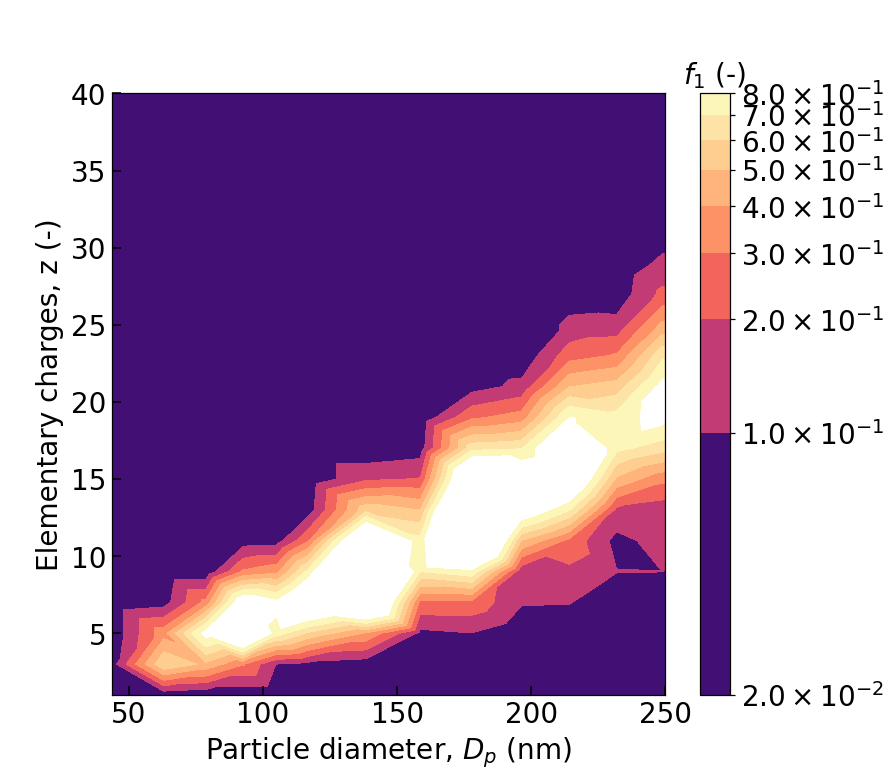

In [16]:
ESPV = np.unique(measurements_data_avg['ESP_V (kV)'])

for espV in ESPV:
    data = measurements_data_avg[measurements_data_avg["ESP_V (kV)"] == espV].copy()
    tDMA_support.Show_countour(data,
                     "2d-deconvoluted ESP V="+str(espV)+" kV",
                     espV,
                     z = "z1",
                     column = "f1",
                     cmap = 'magma',
                     size_x = 8,
                     size_y = 7,
                    normalized=False,
                    reshape_DZ=False,
                    logscale=True,
                    logxscale=False,
                    logyscale=False,
                    zmax=40,
                    dmax=250,
                    export=False)

In [17]:
# Export the results
measurements_data_avg.to_csv('tDMA_deconvoluted.dat', index=False, sep=',')  